# <center> Практические задания по цифровой обработке сигналов </center>
## <center> Вторая лабораторная работа </center>
## <center> Анализ сигналов </center>
**Булаев Владимир, группа DS-22**

In [1]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise') 
%matplotlib inline

In [2]:
# Определим две функции для отрисовки сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()
    

In [3]:
# Создадим несколько простых сигналов. Они нам понадобятся для дальшейшего тестирования
signals = {}

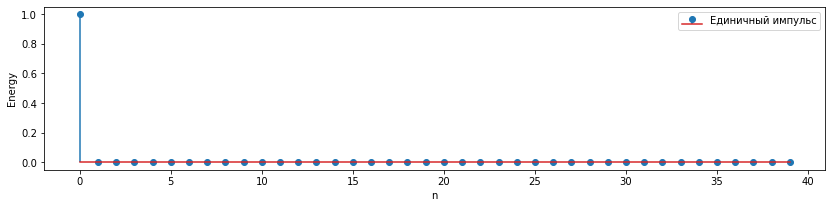

In [4]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0]*39, dtype=float)
draw_sig(signals[name], name)

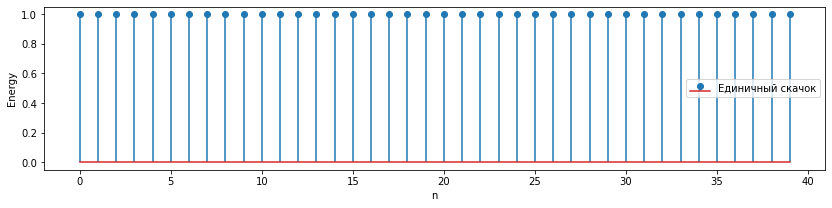

In [5]:
name = "Единичный скачок"
signals[name] = np.array([1]*40 ,dtype=float) 
draw_sig(signals[name], name)

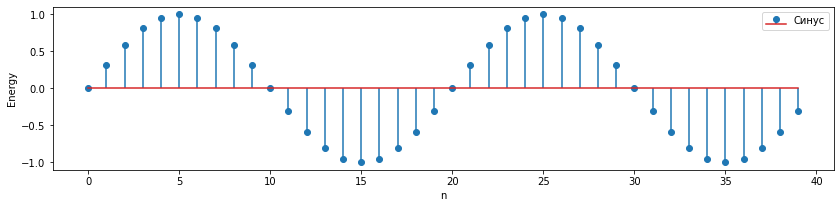

In [6]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40)/10)
draw_sig(signals[name], name)

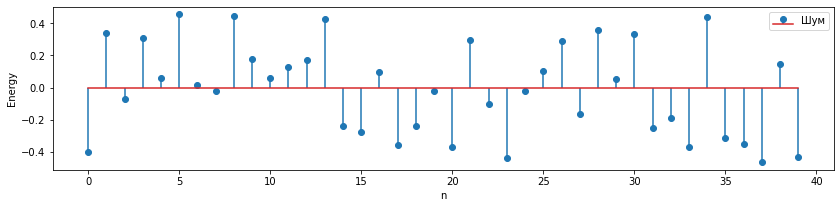

In [7]:
name = "Шум"
signals[name] = np.random.random(40)-0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде, чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье. 
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT)):
$$ X_k = \sum_{n=0}^{N-1} x_n * e^{-2i\pi k n/N} $$
$$ i = \sqrt{-1}$$


# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией scipy.fft.fft

In [8]:
# Реализация стандартного ДПФ. На выходе - массив комплексных чисел
def DFT(x):
    length = len(x)
    # Обязательно необходимо указать dtype = 'complex', иначе numpy отбросит комплексную часть
    result = np.zeros(length, dtype = 'complex')
    # Цикл по элементам спектра
    for k in range(length):
        # Цикл по отсчетам исходного сигнала
        for n in range(length):
            result[k] += x[n] * np.exp(-2j * np.pi * k * n / length)
    return result

In [9]:
def test_DTF(x, transform=DFT):
    # Сравнение с библиотекой scipy
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}")
        print(f"Your DTF spectrogram: {curr_result}")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток - сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N log(N))$, что делает его значительно более быстрым на длинных последовательностях. 

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с scipy.fft.fft

In [10]:
def FFT(x):
    length = len(x)
    # Для малого количества точек используем обычное ДПФ
    if length <= 6:
        return  x.dot(np.exp(-2j * np.pi * (np.arange(length) / length) * np.arange(length)[:, np.newaxis]))
    # Рекурсивно вычисляем БПФ для четных и нечетных элементов массива
    even = FFT(x[::2])
    odd  = FFT(x[1::2])
    # Объединяем полученные значения
    factor = np.exp(-2j * np.pi * np.arange(length) / length)
    return np.concatenate([even + factor[:length // 2] * odd,
                           even + factor[length // 2:] * odd])

In [11]:
for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig, transform=FFT) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый - как меняется угол, образуемый на комплексной плоскости. 
# Задание 2 (1 балл)

Реализовать функции построения амплитудного и фазового спектра

In [12]:
# Функция построения амплитудного спектра
def get_amplitude_from_spec(spec):
    # Вещественная часть комплексного спектра
    real = np.real(spec)
    # Мнимая часть комплексного спектра
    imag = np.imag(spec)
    # Возвращаем амплитудный спектр
    return np.sqrt(real ** 2 + imag ** 2)

# Функция построения фазового спектра
def get_phi_from_spec(spec):
    # Вещественная часть комплексного спектра
    real = np.real(spec)
    # Мнимая часть комплексного спектра
    imag = np.imag(spec)
    # Возвращаем фазовый спектр
    return np.arctan2(imag, real)

In [13]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad var. Expected {var}, got {np.var(sig)}")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong Amplitude"
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong Phase"

    
_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  Amplitude"
assert get_amplitude_from_spec(_spec)[0] == 10, \
    "Wrong Amplitude"
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase"

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
assert get_amplitude_from_spec(_spec).round(1)[1] == 11.2 , \
    "Wrong Amplitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5 , \
    "Wrong Amplitude. Make sure it is an angle."

   
print("All OK!")

All OK!


In [14]:
# Определим еще одну функцию для отрисовки
# Теперь будем рисовать сигнал в частотной области
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо, 
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot
    
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Amplitude spectrum")
        spec_A = get_amplitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
        
    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return 

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции signals и ответьте на вопросы:
1. Почему амплитуда всех гармоник единичного импульса равна константе? 
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый? 
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

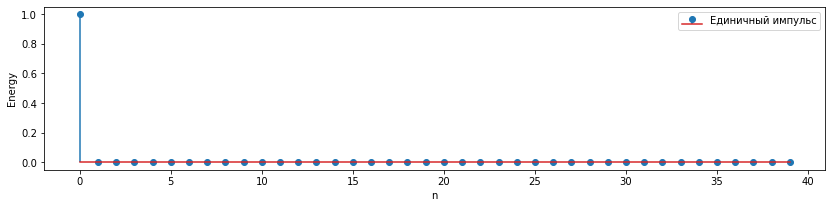

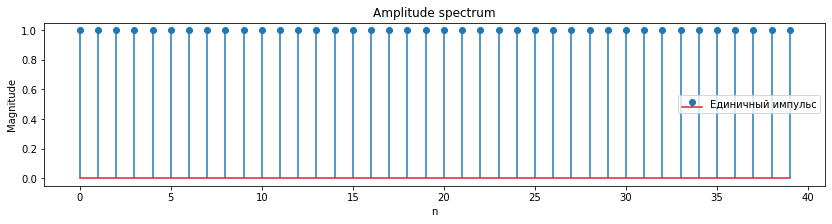

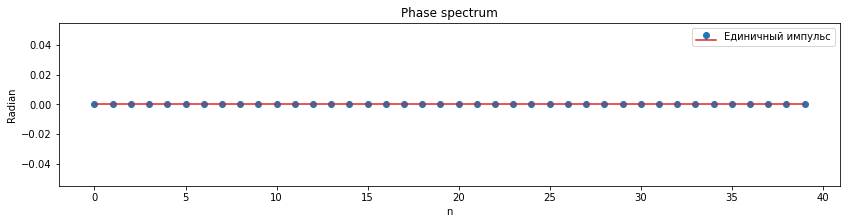

In [15]:
name = "Единичный импульс"
draw_sig(signals[name], name)
draw_spec(DFT(signals[name]), name)

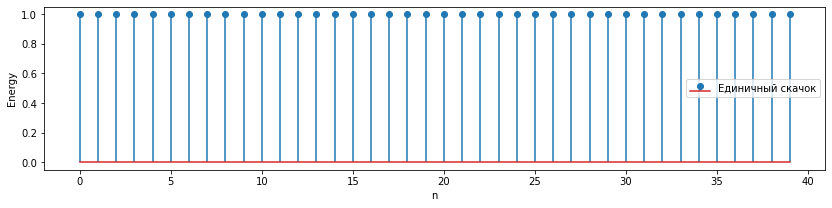

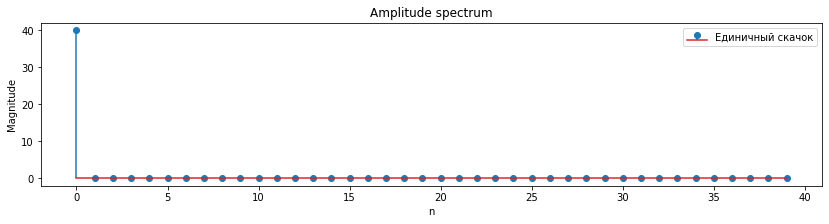

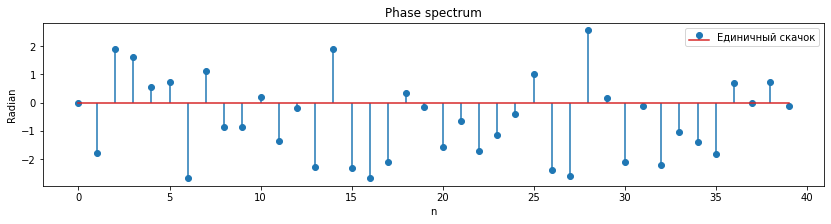

In [16]:
name = "Единичный скачок"
draw_sig(signals[name], name)
draw_spec(DFT(signals[name]), name)

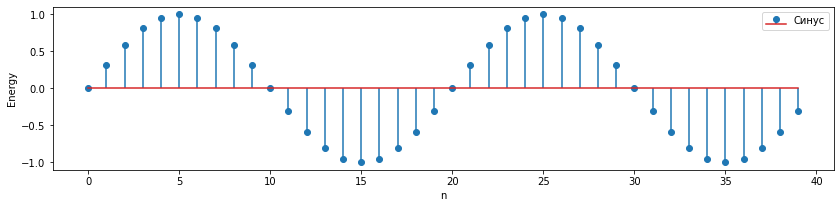

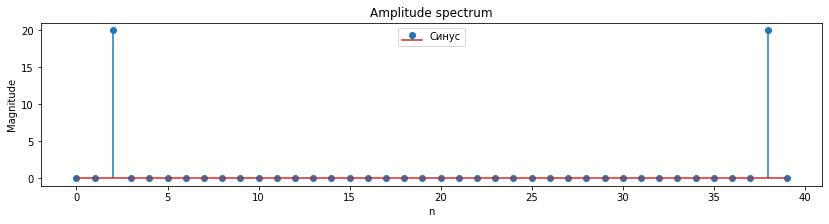

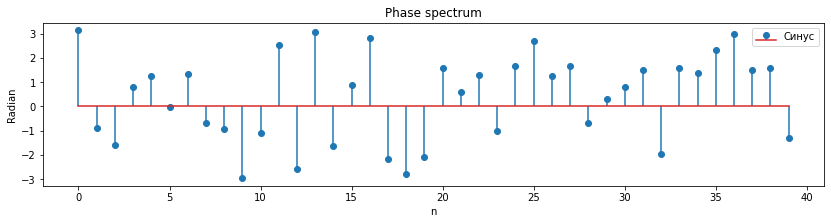

In [17]:
name = "Синус"
draw_sig(signals[name], name)
draw_spec(DFT(signals[name]), name)

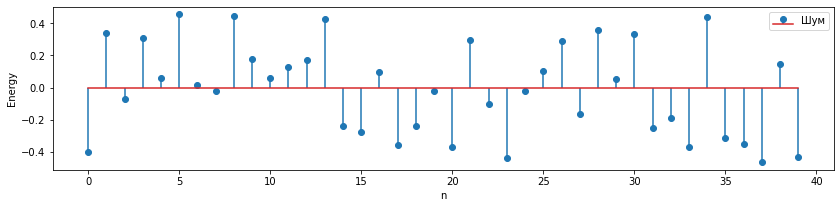

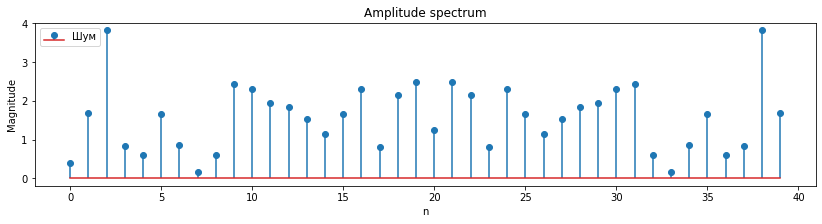

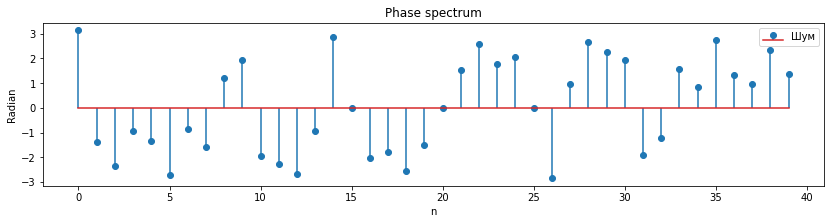

In [18]:
name = "Шум"
draw_sig(signals[name], name)
draw_spec(DFT(signals[name]), name)

Ответы:
1. "*Почему амплитуда всех гармоник единичного импульса равна единице?*" - Потому, что для любой частоты (любое k из формулы ДПФ) под знаком суммы мы получим одно слагаемое, равное 1 (при n=0), все остальные будут равны 0 (т.к. исходный сигнал равен нулю вне импульса).  
2. "*Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый?*" - Исходный сигнал представляет собой сумму гармонических колебаний, каждое из которых имеет свою амплитуду и фазу. По амплитудному спектру можно судить об амплитуде соответствующих гармоник в исходном сигнале (т.е. об их интенсивности), по фазовому - об их фазе (т.е. о моментах появления гармоник).
3. "*Как перевести номер отсчета в частоту?*" - Для этого необходимо номер нужной гармоники поделить на общее количество отсчетов спектра, и полученное значение умножить на частоту дискретизации исходного сигнала: Fk = (k / N) * Fд.
4. "*Что в фазовом спектре является полезной информацией, а что - шумом? Почему?*" - Для восстановления сигнала из спектра нам нужен весь спектр, поэтому без знания априорной информации о сигнале нельзя сказать, какая часть фазового спектра является шумом, а какая полезной частью. Если бы мы знали, что например исходный сигнал является низкочастотным, то тогда можно было бы сказать, что низкочастотная часть фазового спектра является полезной информацией, а высокочастотная - шумом. Но в общем случае весь фазовый спектр является полезной информацией.

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [Оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.
# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье, пользуясь только библиотеками numpy и scipy. Сравнить с librosa.stft


In [19]:
#  Short-time Fourier transform - Оконное преобразование Фурье
def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    # x - signal, n_fft - fft window size 
    # hop_length - step size between ffts, window - window type
    # Оконная функция
    w = scipy.signal.get_window(window, n_fft)
    # Спектр, получаемый после ДПФ, симметричен относительно середины массива.
    # Уникальными являются половина спектра плюс нулевая гармоника.
    # Чтобы не загромождать выходной массив, будем считать спектр только до середины - K
    K = n_fft // 2 + 1
    # Делаем паддинг - дополняем сигнал слева и справа размером в половину длины окна анализа.
    # Слева добавляем зеркальное отражение начальных К отсчетов (нулевой не берется) x[1:K][::-1].
    # Справа добавляем зеркальное отражение последних К отсчетов (самый последний не берется).
    padded = np.hstack([x[1:K][::-1], x, x[len(x) - K - 1:-1][::-1]])
    result = []
    i = 0
    # Пока правая граница окна анализа не перешла границу массива, двигаем окно анализа 
    while i + n_fft < len(padded):
        # Расчет БПФ дополненного сигнала, взвешенного оконной функцией
        spec = scipy.fft.fft(w * padded[i:i + n_fft])[:K]
        result.append(spec)
        i += hop_length
    return np.array(result).T

In [20]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != librosa stft shape {librosa_result.shape} ")
        return -1 
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result-result)}")
        return -2
    return 0
        
for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            assert test_stft(sig, n_fft=n_fft, hop_length=hop_length)==0, \
                f"Test failed. Params n_fft {n_fft}. Hop_length {hop_length}"
    print("ok")
print("All ok!")

Checking 'Единичный импульс'
ok
Checking 'Единичный скачок'
ok
Checking 'Синус'
ok
Checking 'Шум'
ok
All ok!


In [21]:
# Определим функцию для отрисовки
def draw_stft(X, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    # X - комплекстная спектрограмма 
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов.
Во время анализа сигналов нам понадобятся все определенные выше инструменты. 


----------------------------------
## Анализ паровозного гудка
Начнем с простого сигнала, состоящего из нескольких основных гармоник и шума.

Len is 82175 ( ). Sample rate is 22050


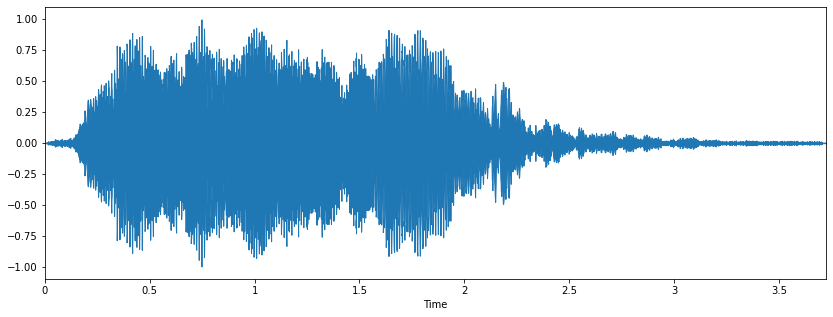

In [22]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("resources/train_whistle.wav")
print(f"Len is {len(train_whistle)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr)

Гудок паровоза в частотной области


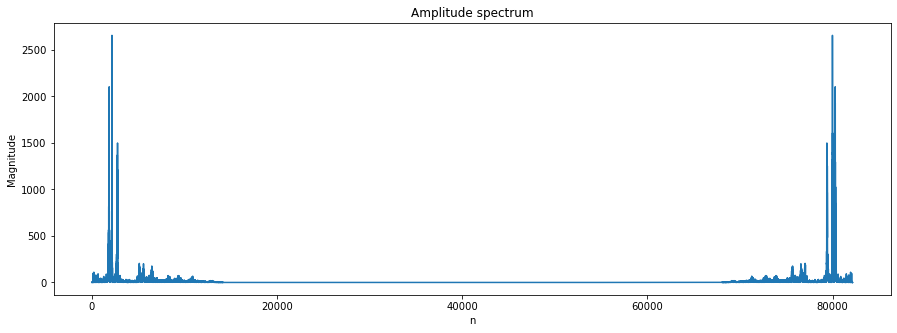

In [23]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec, draw_p=False, figsize=(15,5))

# Задание 4 (2 балла)
Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


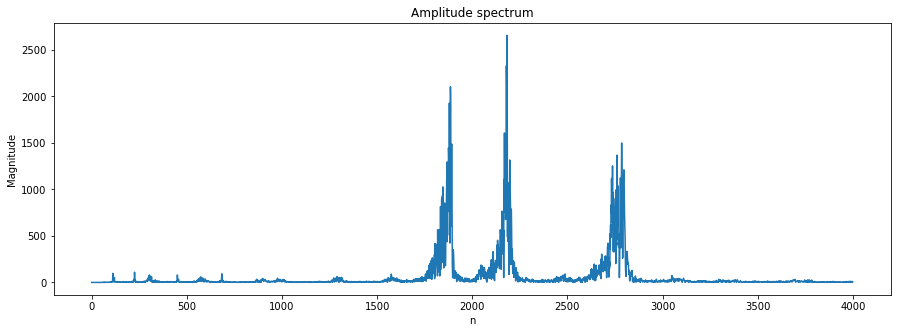

In [24]:
# По графику видно, что 3 основные гармоники сосредоточены в низкочастотной части спектра до частоты 4 кГц
# Выведем увеличенный фрагмент амплитудного спектра
draw_spec(train_whistle_spec[:4000], draw_p=False, figsize=(15,5))

In [25]:
# Поскольку сигнал не идеален, пики тоже не являются идеальными. Простой поиск максимумов по всему спектру 
# не даст желаемого результата. Поэтому будем искать максимумы в соответствующих поддиапазонах.
# Рассчитаем амплитудный спектр паровозного гудка в диапазоне до 4000 отсчетов
amp_spec = get_amplitude_from_spec(train_whistle_spec)[:4000]

In [26]:
# Первую гармонику ищем в первом поддиапазоне от 1500 до 2000 отсчетов, вторую: 2000-2500, третью: 2500-3000.
# Для перевода индекса максимума в частоту прибавим к найденному argmax смещение - т.е. найдем абсолютный аргумент.
# Полученное значение умножим на чатоту дискретизации и поделим на длину массива спектра.
freq1 = np.round(tw_sr * (np.argmax(amp_spec[1500:2000]) + 1500) / len(train_whistle_spec), 2)
freq2 = np.round(tw_sr * (np.argmax(amp_spec[2000:2500]) + 2000) / len(train_whistle_spec), 2)
freq3 = np.round(tw_sr * (np.argmax(amp_spec[2500:3000]) + 2500) / len(train_whistle_spec), 2)
task_answer = [freq1, freq2, freq3]
print('3 основные гармоники паровозного гудка (Гц):', task_answer)

3 основные гармоники паровозного гудка (Гц): [505.8, 585.76, 747.3]


In [27]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(task_answer)}"
assert len(task_answer) == 3, \
        f"Wrong len {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer)  - 1836) <= 3 and abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong freqs"
print("Correct!")       

Correct!


Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

In [28]:
# Для генерации сигнала просуммируем три синусоиды с частотами найденных гармоник. Длину сделаем равной исходному сигналу.
# Создадим массив времен с шагом дискретизации и длиной в секундах, как в исходном сигнале паровозного гудка.
time = np.linspace(0, len(train_whistle) / tw_sr, len(train_whistle))
# Абсолютные значения амплитуд сгенерированных гармоник особо не важны, но постараемся соблюсти соотношение между ними
A1 = np.max(amp_spec[1500:2000])
A2 = np.max(amp_spec[2000:2500])
A3 = np.max(amp_spec[2500:3000])
# Отнормируем амплитуды к масштабу 1
max_amp = max(A1, A2, A3)
A1 /= max_amp
A2 /= max_amp
A3 /= max_amp
# Т.к. массив времен у нас в секундах, для генерации синусоид просто подставим найденные частоты (в Гц) в синусы
signal = A1 * np.sin(2 * np.pi * freq1 * time) + A2 * np.sin(2 * np.pi * freq2 * time) + \
         A3 * np.sin(2 * np.pi * freq3 * time)

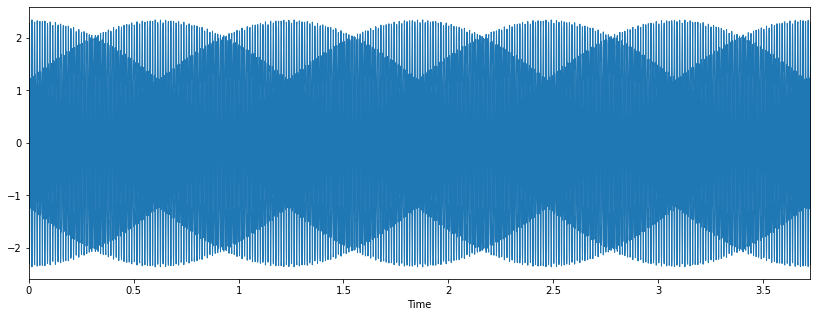

In [29]:
# Воспроизведем сгенерированный сигнал
draw_waveform(signal, sr=tw_sr)
ipd.Audio(signal, rate=tw_sr)

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал - [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера. 

# Задание 5 (2 балла)
В данном аудио закодирован трехзначный номер. Используя таблицу с [wiki]:(https://ru.wikipedia.org/wiki/DTMF) определите, что за номер закодирован.


Len is 243102. Sample rate is 22050


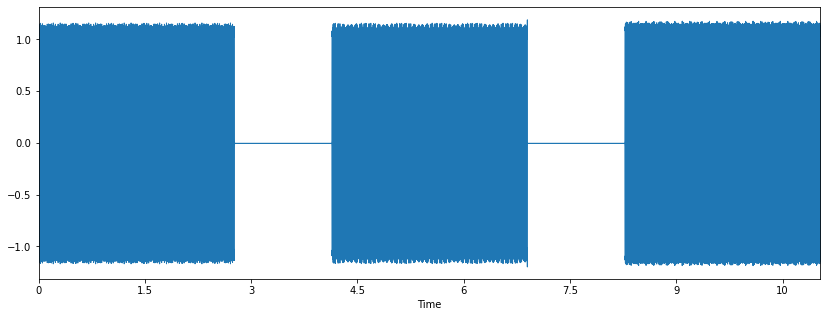

In [30]:
dtmf, dtmf_sr = librosa.core.load("resources/dtmf.wav")
print(f"Len is {len(dtmf)}. Sample rate is {dtmf_sr}")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

In [31]:
# Для решения задачи необходимо найти частоты основных гармоник. 
# Видно, что в данных есть 3 зоны, занимающие примерно треть временной протяженности сигнала.
# Эти зоны соответствуют трем набранным цифрам. В каждой из них свои основные гармоники.
# Проведем по ним раздельный анализ, аналогичный анализу паровозного гудка.
result = []
# Ширина зоны, в которой нажата определенная кнопка
band = len(dtmf) // 3
# Цикл по зонам с разным частотным составом
for i in range(3):
    # Начало зоны анализа
    start = i * band
    # Конец зоны анализа
    stop = min((i + 1) * band, len(dtmf))
    # Расчет амплитудного спектра 
    spec = get_amplitude_from_spec(scipy.fft.fft(dtmf[start: stop]))
    # dtmf-сигнал содержит 2 основных гармоники. В информативной части спектра (т.е. в его первой половине)
    # найдем аргументы 2-х максимумов спектра
    freq = spec[:len(spec) // 2].argsort()[-2:]
    # Переведем частоты в герцы
    freq = np.round(freq * dtmf_sr / len(spec))
    result.append(freq)
result = np.array(result)    

In [32]:
print('Найденные значения основных гармоник в сигнале dtmf:')
print(result)

Найденные значения основных гармоник в сигнале dtmf:
[[ 697. 1209.]
 [ 770. 1336.]
 [ 852. 1477.]]


In [33]:
# Пользуясь таблицей перевода тонального сигнала, получим результат
phone_number = [1, 5, 9]

In [34]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(phone_number)}"
assert len(phone_number) == 3, \
        f"Wrong len {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11 , \
        f"Wrong number"
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == "140f6969d5213fd0ece03148e62e461e", \
        f"Wrong hash. How did you pass mean/var test?"
print("Correct!")   

Correct!
